# Tutorial

In [44]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from core.input import input_format
from core.masking import create_padding_mask
from core.astromer import get_ASTROMER, get_FINETUNING, train
from core.data  import (create_dataset, 
                        standardize,
                        load_records)

# This tutorial runs only in early mode. For the optimized code use train.py
# OTHERWISE you can comment the next ljupyine and reset the kernel before the finetuning
tf.config.run_functions_eagerly(True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
source = './data/raw_data/MACHO/' # lightcurves folder
metadata = 'data/raw_data/MACHO/MACHO_dataset.dat' # metadata file
target = 'data/records/macho/' # where records will be stored

### Metadata frame sample

In [50]:
meta_sample = pd.read_csv(metadata).sample(1)
meta_sample

,Unnamed: 0,Class,N,Path,Band
1907,1907,MOA,1803,LCs/lc_119_20352_2589_B_mjd.dat,B


### Lightcurve frame sample

In [51]:
lc_df = pd.read_csv(os.path.join(source,  meta_sample['Path'].values[0]))
lc_df.head()

,mjd,mag,errmag
0,49045.572859,-6.110,0.046
1,49048.553831,-6.049,0.145
2,49049.566100,-6.058,0.050
3,49060.549502,-6.107,0.023
4,49061.582326,-6.108,0.033


### From .csv to .record 

In [52]:
# create_dataset(source, metadata, target, max_lcs_per_record=1000)

### Loading Data

In [53]:
batch_size = 10
input_len = 50

In [54]:
# Loading data

train_batches = load_records(os.path.join(target, 'train'), 
                             batch_size, 
                             input_len=input_len,
                             balanced=True)
valid_batches = load_records(os.path.join(target, 'val'), 
                             batch_size, 
                             input_len=input_len,
                             balanced=True)
test_batches = load_records(os.path.join(target, 'test'), 
                             batch_size, 
                             input_len=input_len)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


### Visualizing Records

In [55]:
input_len = 100 # maximum lightcurve length
batch_size = 10
dataset = load_records(target+'/train', batch_size=batch_size, input_len=input_len)

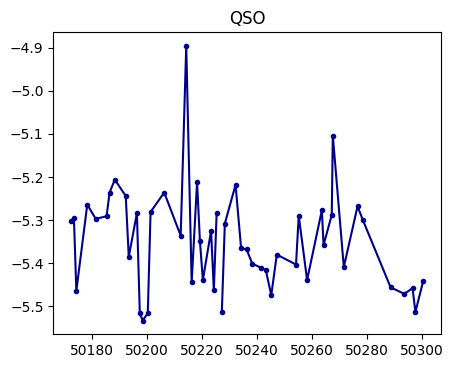

In [56]:
n = 0
fig, axes = plt.subplots(1,1, figsize=(5,4),dpi=100)
for batch in train_batches:
    mask_1 = create_padding_mask(batch['serie_1'], batch['steps_1']-1)
    mask_2 = create_padding_mask(batch['serie_2'], batch['steps_2']-1)

    serie_1 = tf.boolean_mask(batch['serie_1'][n], tf.logical_not(mask_1[n]))
    serie_2 = tf.boolean_mask(batch['serie_2'][n], tf.logical_not(mask_2[n]))

    y = batch['label'][n]
    objects = pd.read_csv(os.path.join(target, 'objects.csv'))
    cls_label = objects.iloc[int(y)]['label']

    axes.plot(serie_1[:, 0], serie_1[:, 1], '.-', color='darkblue')
    axes.plot(serie_2[:, 0], serie_2[:, 1], '.-', color='darkblue')
    axes.set_title(cls_label)
    break

## ASTROMER

### Input Layer

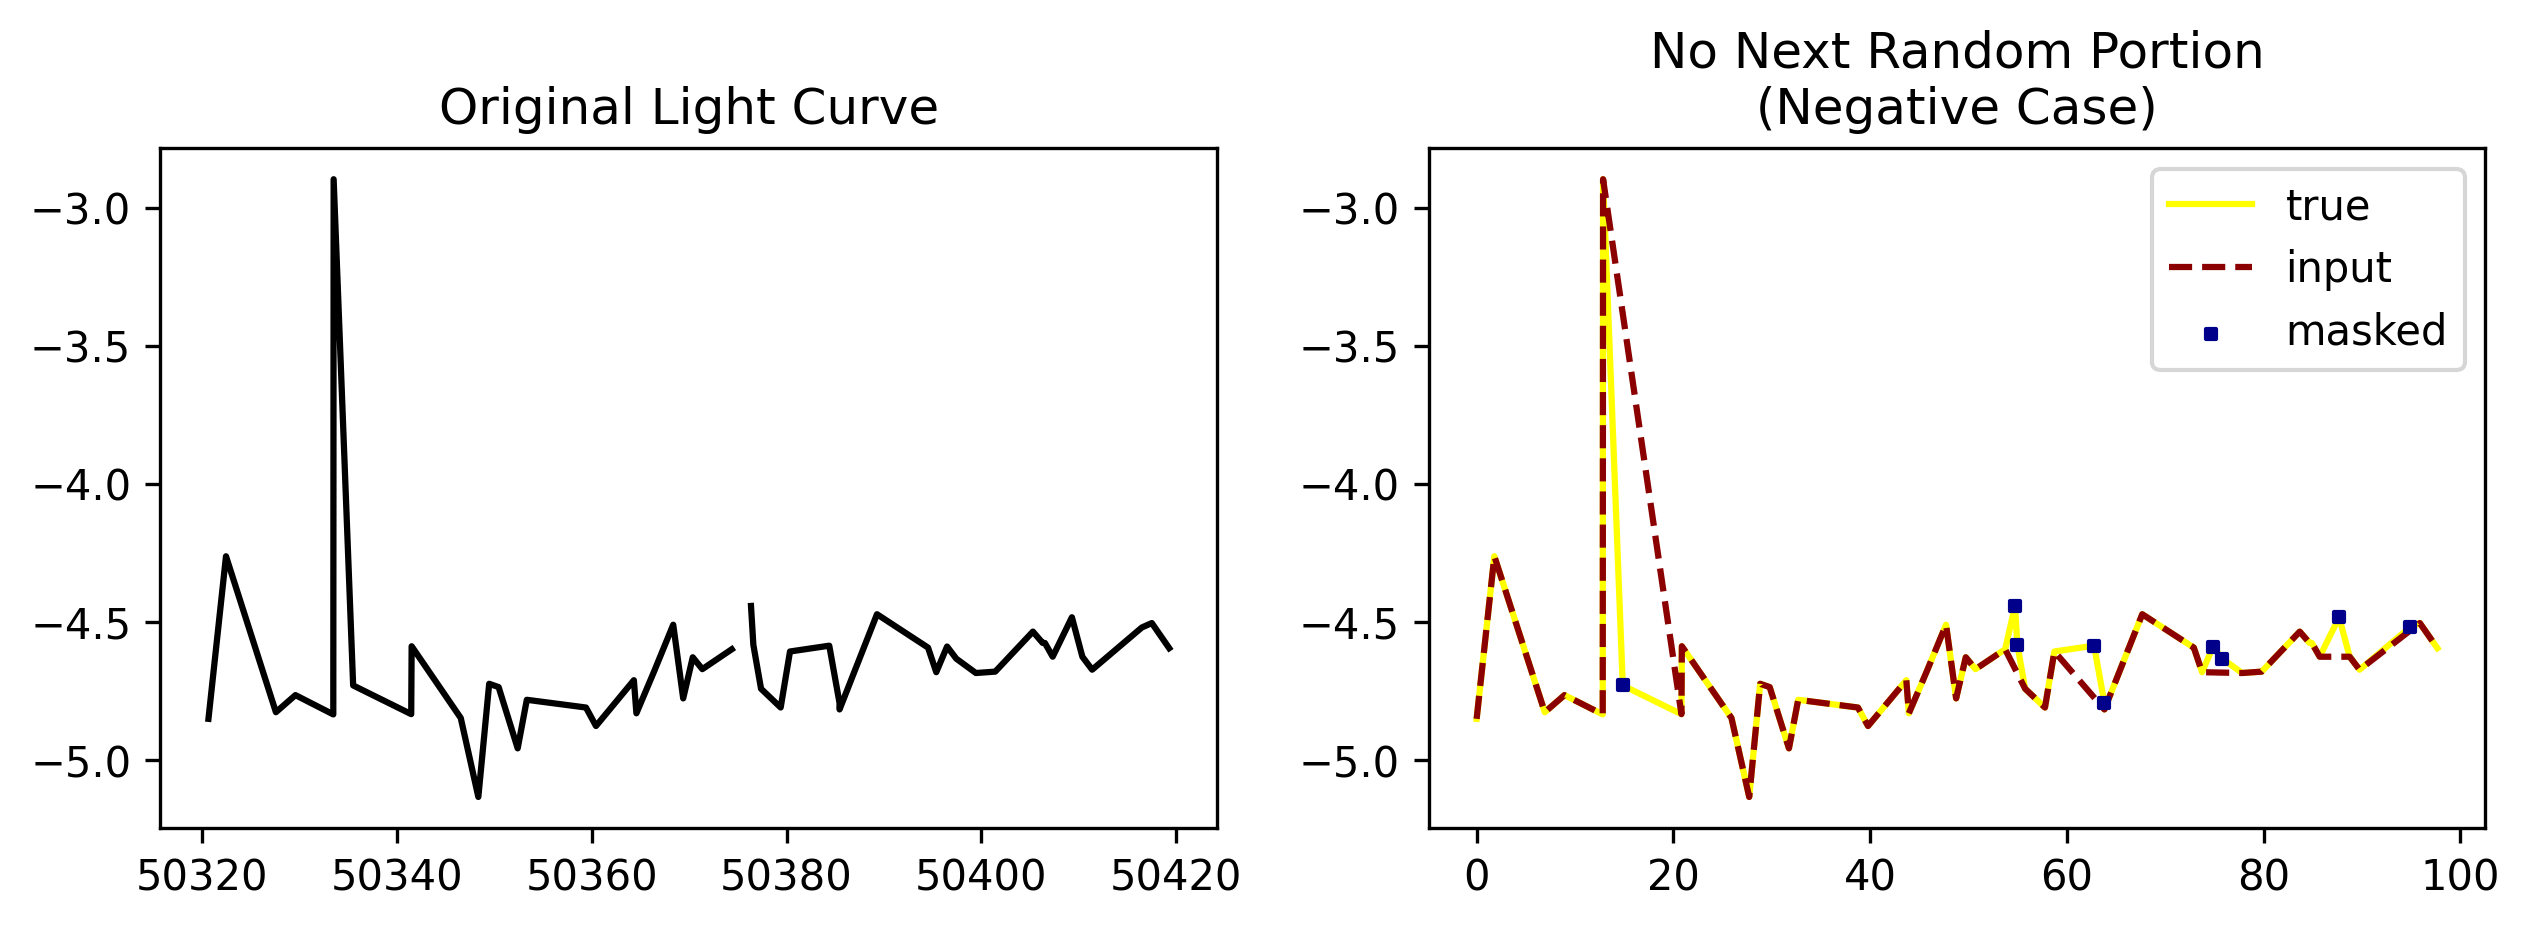

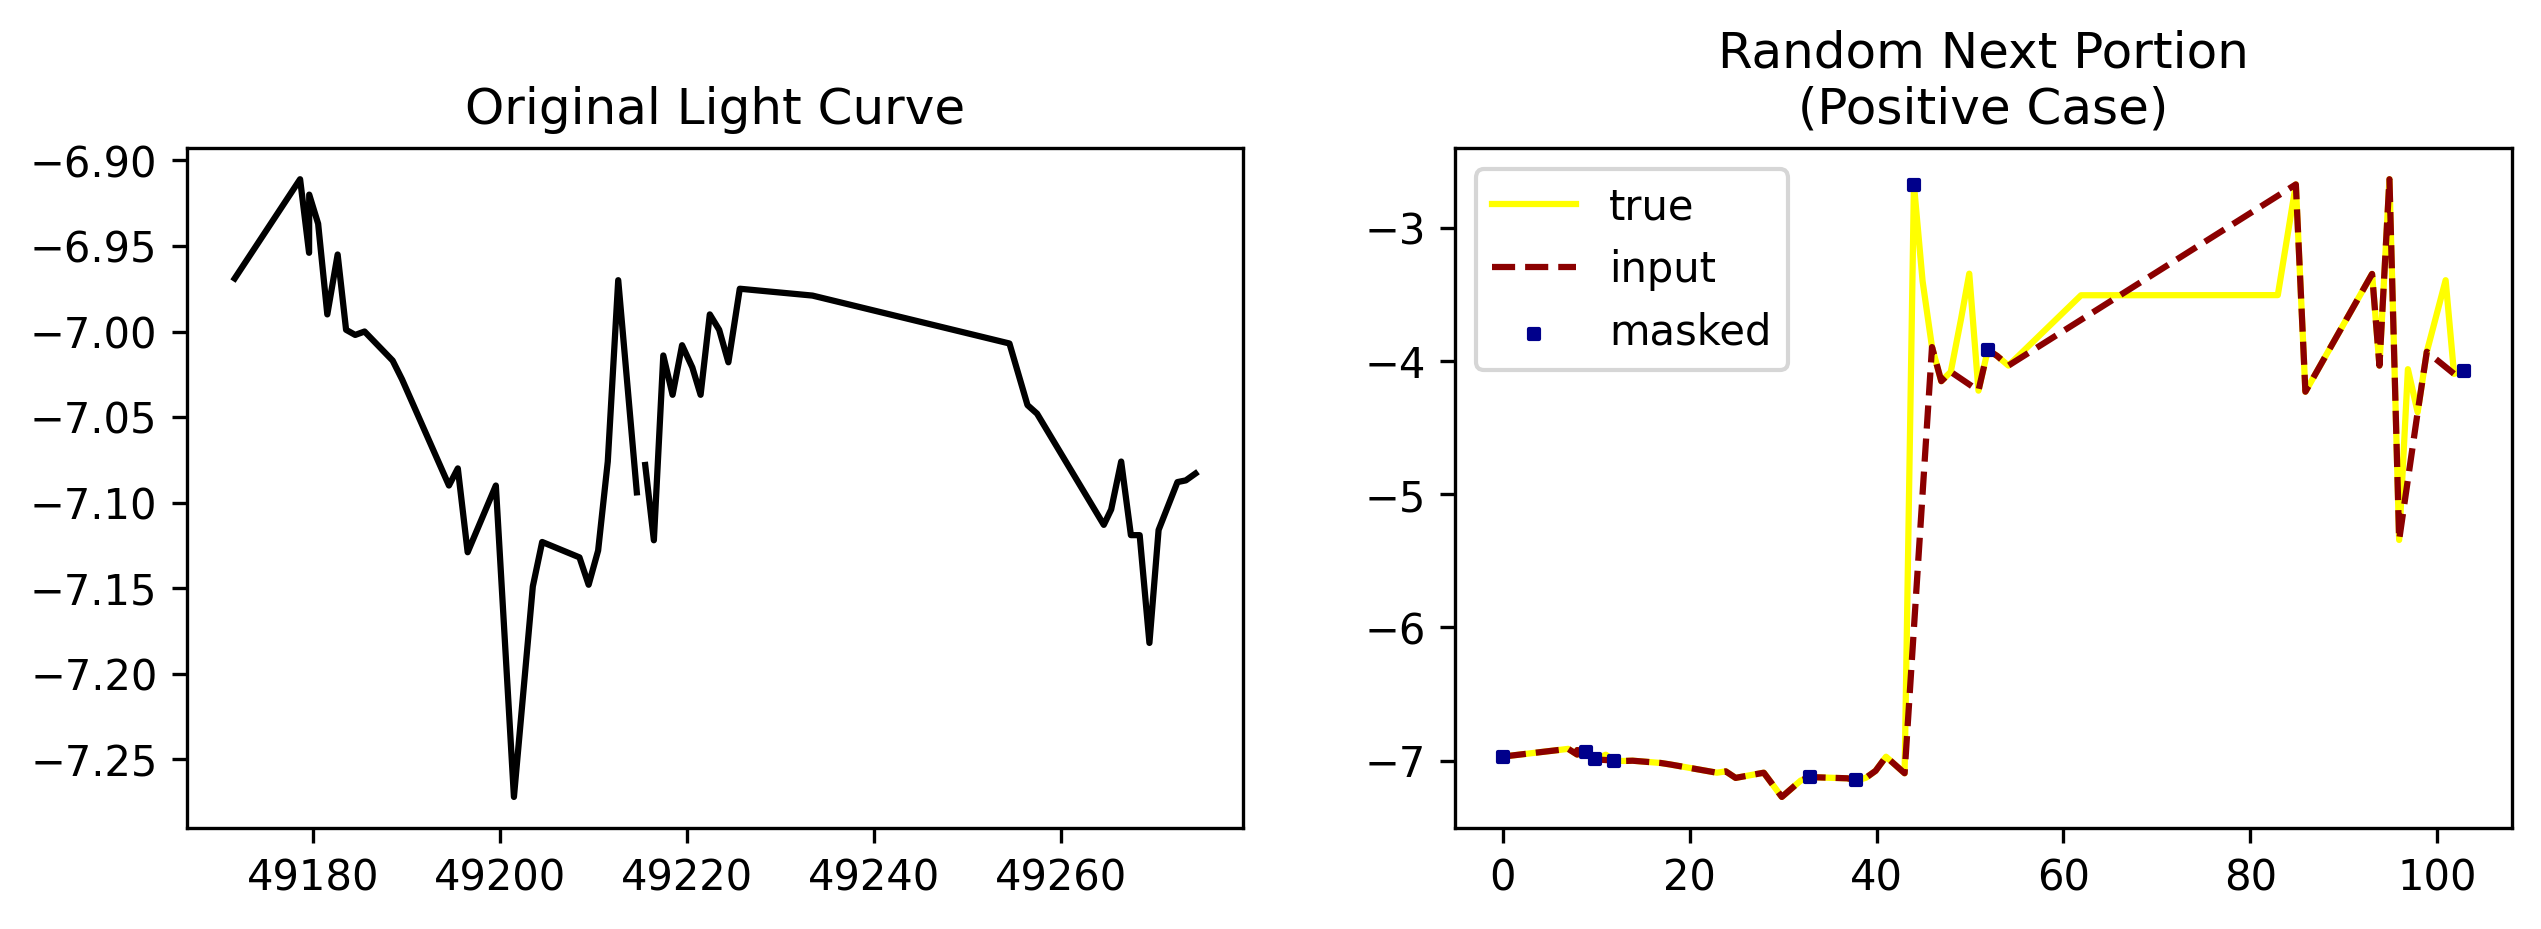

In [58]:

count = 0
for batch in train_batches:
    inputs, targets = input_format(batch)
    
    pos, neg = 0, 0
    for n in range(len(inputs)):
        if targets['y_true'][n][:, 0].numpy() == 1:
            title = 'Random Next Portion\n(Positive Case)'
            pos += 1
            if pos > 1: continue
        else:
            title = 'No Next Random Portion\n(Negative Case)'
            neg += 1
            if neg > 1: continue
        
        fig, axes = plt.subplots(1, 2, figsize=(10,3), dpi=300)
        # Input Mask
        inp_mask = inputs['mask'][0]
        inp_mask = tf.transpose(inp_mask, [1,2,0])
        inp_mask = tf.cast(tf.logical_not(tf.cast(inp_mask, tf.bool)), tf.float32)
        inp_mask = tf.squeeze(inp_mask[n])

        # Target Mask
        mask = targets['x_mask'][n] # target mask (values to be prediceted)

        # INPUT
        inp_time = inputs['times'][n][:, 0] # times
        inp_magn = inputs['values'][n][:, 0] # magnitudes

        x_time   = inp_time[1:]
        x_magn   = tf.multiply(inp_magn, inp_mask)[1:]
        x_masked = tf.multiply(inp_magn[1:], mask)

        t_inp, t_masked = [], []
        m_inp, m_masked = [], []
        for t1, x1, x2 in zip(x_time, x_magn, x_masked):
            if x1 != 0 and x1 != -99:
                t_inp.append(t1)
                m_inp.append(x1)
            if x2 != 0:
                t_masked.append(t1)
                m_masked.append(x2)

        m_true = targets['x_true'][n][:, 0]
        m_true = m_true[m_true != -99]
        t_true = x_time[x_time != -99]


        # PLOT ORIGINAL SERIES
        axes[0].plot(batch['serie_1'][n][:, 0], batch['serie_1'][n][:, 1], color='k')
        axes[0].plot(batch['serie_2'][n][:, 0], batch['serie_2'][n][:, 1], color='k')
        axes[0].set_title('Original Light Curve')

        # PLOT POST INPUT LAYER SERIES
        axes[1].plot(t_true, m_true, label='true', color='yellow',zorder=1)
        axes[1].plot(t_inp, m_inp, '--', label='input', color='darkred',zorder=2)

        axes[1].scatter(t_masked, m_masked, label='masked', color='darkblue', s=5, marker='s',zorder=3)
        axes[1].legend()            
        axes[1].set_title(title)
    
        if pos>=1 and neg>=1:
            break
    break

# Training

In [18]:
astromer = get_ASTROMER(maxlen=50)

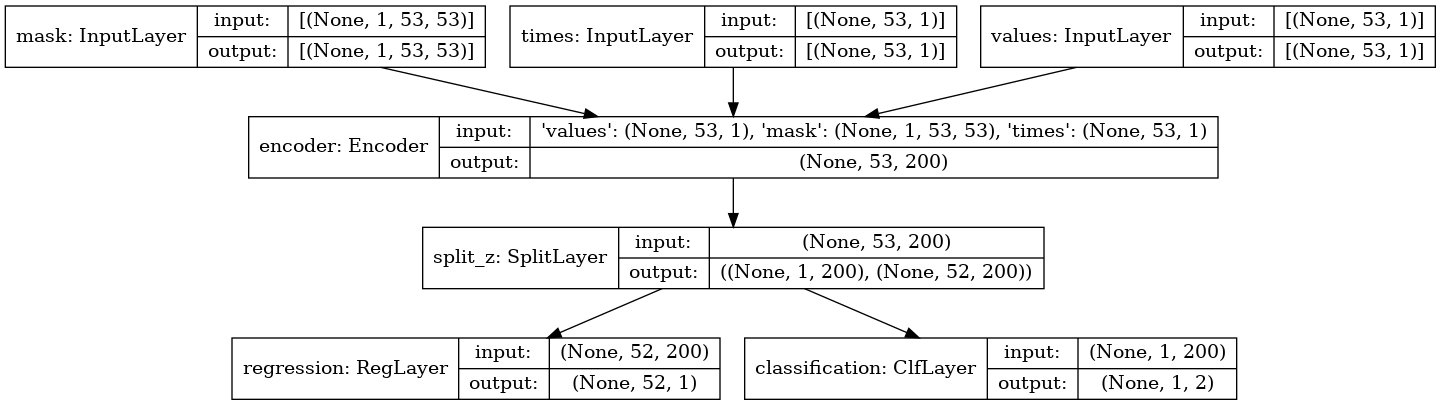

In [19]:
tf.keras.utils.plot_model(astromer, show_shapes=True)

In [12]:
train(astromer, train_batches, valid_batches, epochs=2)

train: 315it [01:55,  2.73it/s]
validation: 157it [00:50,  3.12it/s]


tf.Tensor(94.8064, shape=(), dtype=float32)


train: 315it [02:00,  2.62it/s]
validation: 157it [00:46,  3.40it/s]

tf.Tensor(7.8247166, shape=(), dtype=float32)


# FINETUNNING

In [13]:
astromer = get_ASTROMER()

In [14]:
astromer.load_weights('./experiments/test/weights')

In [15]:
ft_model = get_FINETUNING(astromer, num_cls=10)

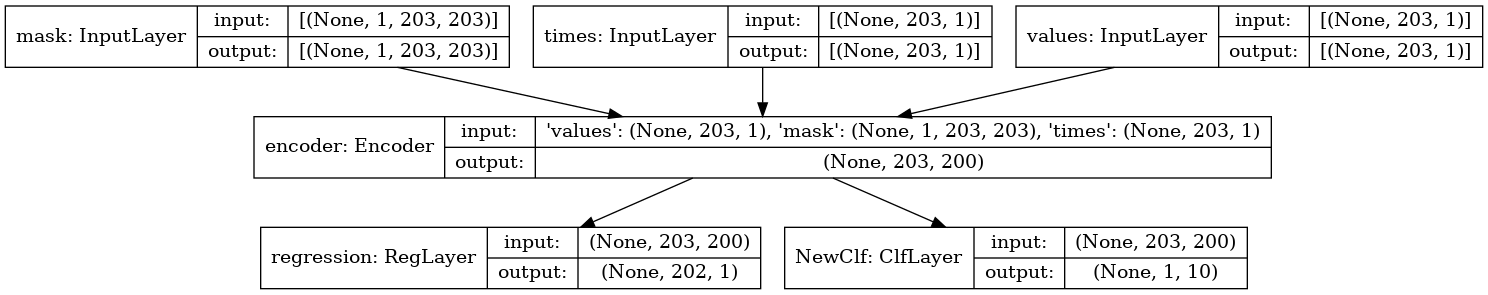

In [16]:
tf.keras.utils.plot_model(ft_model, show_shapes=True)

In [17]:
train(ft_model, train_batches, valid_batches, epochs=2, num_cls=10)

train: 315it [02:01,  2.58it/s]
validation: 157it [00:48,  3.22it/s]


tf.Tensor(3.4514093, shape=(), dtype=float32)


train: 315it [01:54,  2.75it/s]
validation: 157it [00:45,  3.46it/s]
